### Objective: To develop and test functions for performing initial analysis of trajectories. 

I am going to test and compare MDTraj/MDTraj/pytraj.

In [18]:
import MDAnalysis  as mda
from nglview.datafiles import PDB, XTC
import MDAnalysis.analysis
import mdtraj as md
import pytraj as pt
import nglview as nv
import numpy as np
import pandas as pd

import warnings
# suppress some MDAnalysis warnings about PSF files
warnings.filterwarnings('ignore')



import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from vir_md_analysis.utils import ls
from vir_md_analysis.features.structural_features import calculate_rg_for_specific_region

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load the trajectories with MDAnalysis

In [2]:
data_dir = Path().cwd().parent.parent / 'vir_md_analysis' / 'data'
print(f'Data dir exists: {data_dir.exists()}')
ls(data_dir)

Data dir exists: True


['README.md', '4md.nc', 'prep4.pdb', 'look_and_say.dat', '2md.nc', '3md.nc']

#### Use the demo trajectory for now. 

In [6]:
u = mda.Universe(PDB, XTC)
protein = u.select_atoms('protein')
view = nv.show_mdanalysis(protein)
view.add_representation('cartoon')
view

NGLWidget(max_frame=50)

#### MD analysis to compute radius of gyration: 

Below I am computing the radius of gyration for the protein and backbone regions of the trajectory.
For the entire protein, I am using the code in the cell. For the backbone, I call the function `calculate_rg_for_specific_region` which is defined in `vir_md_analysis.features.structural_features.py` file.

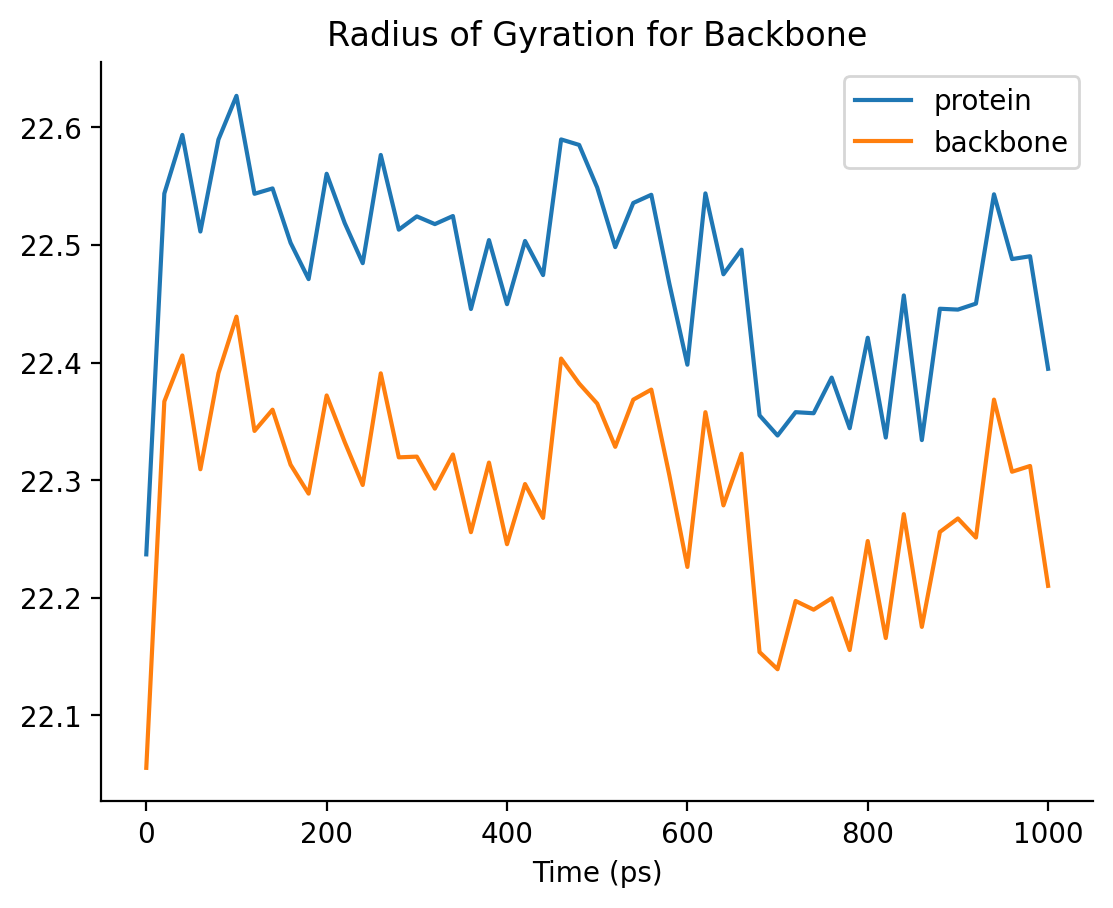

In [29]:
rad_gy=[]
time = []
frame =[]

for ts in u.trajectory: 
    time.append(u.trajectory.time)
    rad_gy.append(protein.radius_of_gyration())
    frame.append(ts.frame)

rg_df = pd.DataFrame({'Frame' : frame, 'Time (ps)': time, 
                     'radius of gyration A':rad_gy})
ax= rg_df.plot(x='Time (ps)', y= 'radius of gyration A', label = 'protein')

rg_backbone_df = calculate_rg_for_specific_region(u, region = 'backbone',)
rg_backbone_df.plot(x='Time (ps)', y= 'Radius of Gyration (A)', 
                    title='Radius of Gyration for Backbone', label = 'backbone', ax= ax)
sns.despine()
